In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import neighbors, datasets
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

In [ ]:
url= "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

In [ ]:
#Import data and name columns
df = pd.read_csv(url,header=None)

# FOR LOOP NAMING COLUMNS
# create the names for the columns
features = ['radius','texture','perimeter','area','smoothness','compactness',
            'concavity','concave_points','symmetry','fractal_dimension']
stat = ['mean','SE','worst']
col = ['id','diagnosis']  # BEFORE: all the column names
predictors = []  # BEFORE: all the predictors

for i in stat:
    for j in features:
        m = str(i+"_"+j)
        col.append(m)
        predictors.append(m)
df.columns = col

df.head()

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
np.random.seed(42)

In [ ]:
#Set up cross validation
inner_cv = KFold(n_splits=5, shuffle=True,random_state=42) # inner cross-validation folds
outer_cv = KFold(n_splits=5, shuffle=True,random_state=42)

In [ ]:
#Specify target variable and encode labels
X = df.iloc[:, 2:32].values      # specify attributes/predictors
y = df.iloc[:, 1].values       # specify target variable
le = LabelEncoder()
y = le.fit_transform(y)       # labels 'M' as 1 and 'B' as 0

In [ ]:
#Decision Tree Parameter Tuning
#define param options
param_grid_tree = {'max_depth': [1, 2, 3, 4, 5, 6, 7, None],
                               'criterion':['gini','entropy'],
                               'min_samples_leaf':[1,2,3,4,5],
                               'min_samples_split':[2,3,4,5]}

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid_tree,
                  scoring='f1',
                  cv=inner_cv)

gs = gs.fit(X,y)
print("Decision Tree Parameter Tuning")
print("Non-nested CV F1-score: ", gs.best_score_)
print("Optimal Parameter: ", gs.best_params_)    # parameter setting that gave the best results on the hold out data
print("Optimal Estimator: ", gs.best_estimator_) # estimator that was chosen by the search, i.e. estimator which gave highest score
nested_score_gs = cross_val_score(gs, X=X, y=y, cv=outer_cv) #estimate generalization performance (outer cross-validation)
print("Nested CV F1-score: ",nested_score_gs.mean(), " +/- ", nested_score_gs.std())


Decision Tree Parameter Tuning
Non-nested CV F1-score:  0.9321718662895133
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
Optimal Estimator:  DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=0)
Nested CV F1-score:  0.9279245697748815  +/-  0.014408081234541752


In [ ]:
#Logistic Regression Parameter Tuning
#To ignore the convergence warnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#define param options
param_grid_lr = {'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000],
                   'penalty':['l1','l2']}

gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=param_grid_lr,
                  scoring="f1",
                  cv=inner_cv)

gs_lr = gs_lr.fit(X,y)
print("Logistic Regression Parameter Tuning")
print("Non-nested CV F1-score: ", gs_lr.best_score_)
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)
nested_score_gs_lr = cross_val_score(gs_lr, X=X, y=y, cv=outer_cv)
print("Nested CV F1-score:",nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())

Logistic Regression Parameter Tuning
Non-nested CV F1-score:  0.9576785075389728
Optimal Parameter:  {'C': 100, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')
Nested CV F1-score: 0.9420763493534577  +/-  0.025479373765626753


In [ ]:
#kNN Parameter Tuning
#Normalize Data
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('knn', KNeighborsClassifier(p=2,
                                     metric='minkowski'))])

#define param options
param_grid_kNN = {
        'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
        'knn__weights': ['uniform', 'distance']}

gs_knn = GridSearchCV(estimator=pipe,
                  param_grid=param_grid_kNN,
                  scoring="f1",
                  cv=inner_cv,
                  n_jobs=4)

gs_knn = gs_knn.fit(X,y)
print("kNN Parameter Tuning")
print("Non-nested CV F1-score: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_) # Estimator that was chosen by the search,
nested_score_gs_knn = cross_val_score(gs_knn, X=X, y=y, cv=outer_cv)
print("Nested CV F1-score: ",nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())


kNN Parameter Tuning
Non-nested CV F1-score:  0.9523682840047905
Optimal Parameter:  {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Optimal Estimator:  Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])
Nested CV F1-score:  0.9450774508002675  +/-  0.03136189292189269


# Fitting Graph

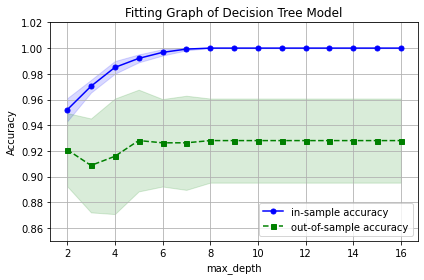

In [ ]:
#Create and label fitting graph to examine the impact of max depth on accuracy
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

param_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

train_scores, test_scores = validation_curve(
                estimator=DecisionTreeClassifier(random_state=42), # build Decision Tree models
                X=X,
                y=y,
                param_name="max_depth",
                param_range=param_range,

                cv=10,
                scoring="accuracy",
                n_jobs=4)


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis (train data)
train_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis (train data)
test_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis (test data)
test_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis (test data)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range,                     # the horizontal coordinates of the data points
         train_mean,                      # the vertical coordinates of the data points
         color='blue',                    # aesthetic parameter - color
         marker='o',                      # aesthetic parameter - marker
         markersize=5,                    # aesthetic parameter - size of marker
         label='in-sample accuracy')       # specify label title

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range,             # the x coordinates of the nodes defining the curves
                 train_mean + train_std,  # the y coordinates of the nodes defining the first curve
                 train_mean - train_std,  # the y coordinates of the nodes defining the second curve
                 alpha=0.15,              # level of transparency in the color fill
                 color='blue')            # aesthetic parameter - color

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range,
         test_mean,
         color='green',
         linestyle='--',
         marker='s',
         markersize=5,
         label='out-of-sample accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.title("Fitting Graph of Decision Tree Model")
plt.legend(loc='lower right')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1.02]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()                            # display the figure



## Learning Curve

In [ ]:
#Preparing learning curve for use with logistic regression
def plot_learning_curve(estimator,        # data science algorithm
                        title,            # title of the plot
                        X, y,             # data (features and target variable)
                        ylim=None,        # minimum and maximum y values plotted
                        cv=None,          # cross validation splits
                        n_jobs=1,         # parallell estimation using multiple processors
                        train_sizes=np.linspace(.1, 1.0, 10)): #linspace returns evenly spaced numbers over a specified interval (start, stop, num)
        plt.figure()                    # display figure
        plt.title(title)                # specify title based on parameter provided as input
        if ylim is not None:            # if ylim was specified as an input, make sure the plots use these limits
            plt.ylim(*ylim)
        plt.xlabel("Training examples") # y label title
        plt.ylabel("Score")

        train_sizes, train_scores, test_scores = learning_curve(estimator, # data science algorithm
                                                            X, y,      # data (features and target variable)
                                                            cv=cv,     # cross-validation folds
                                                            n_jobs=n_jobs, # number of jobs to run in parallel using multiple processors
                                                            train_sizes=train_sizes)

        train_scores_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis.
        train_scores_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis.
        test_scores_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis.
        test_scores_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis.

        plt.grid()

        plt.fill_between(train_sizes,                            # the x coordinates of the nodes defining the curves
                     train_scores_mean - train_scores_std,   # the y coordinates of the nodes defining the first curve
                     train_scores_mean + train_scores_std,   # the y coordinates of the nodes defining the second curve
                     alpha=0.1,                              # level of transparency in the color fill
                     color="r")                              # train data performance indicated with red
        plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")

        # Cross-validation means indicated by dots
        # Train data performance indicated with red
        plt.plot(train_sizes,                                    # the horizontal coordinates of the data points
                 train_scores_mean,                              # the vertical coordinates of the data points
                 'o-',                                           # o- will produce a small circle and a solid line to connect the markers
                 color="r",                                      # line of red color
                 label="Training score")

        # Test data performance indicated with green
        plt.plot(train_sizes,
                 test_scores_mean,
                 'o-',
                 color="g",                                      # line of green color
                 label="Cross-validation score")

        plt.legend(loc="best")                      # show legend of the plot at the best location possible
        return plt

/Users/tgcn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tgcn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/tgcn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tgcn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/tgcn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tgcn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

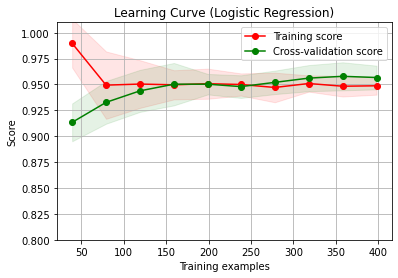

In [ ]:
#Deploy learning curve to examine how the number of training examples affects accuracy
title = "Learning Curve (Logistic Regression)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.3,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0)
                  random_state=42)      # the seed used by the random number generator
estimator = LogisticRegression()

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X, y,           # data (features and target variable)
                    (0.8, 1.01),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show()

## ROC

10-fold cross validation:

ROC AUC: 0.99 (+/- 0.01) [Logistic regression]
ROC AUC: 0.96 (+/- 0.04) [Decision tree]
ROC AUC: 0.99 (+/- 0.01) [kNN]


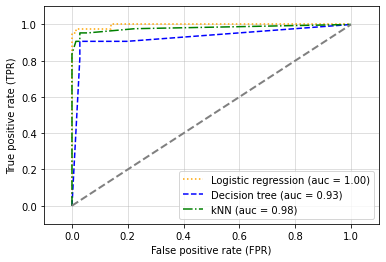

In [ ]:
#ROC curve for the created models to examine performance
# Logistic Regression Classifier
clf1 = LogisticRegression(penalty='l1',
                          C=100,
                          random_state=42,
                          solver='liblinear')

# Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=4,
                              criterion='gini',
                              min_samples_leaf=5,
                              min_samples_split=2,
                              random_state=42)


# kNN Classifier

clf3 = Pipeline([
        ('sc', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=9,
                                     weights='uniform',
                                     p=2,
                                     metric='minkowski')) ])

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [clf1, clf2, clf3]

#################################### Cross - Validation ####################################


print('10-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers
    scores = cross_val_score(estimator=clf,  # estimate AUC based on cross validation
                             X=X,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" # print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # colors for visualization
linestyles = [':', '--', '-.', '-']        # line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # make predictions based on the classifiers

    fpr, tpr, thresholds = roc_curve(y_true=y_test,       # build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                           # compute Area Under the Curve (AUC)
    plt.plot(fpr, tpr,                                    # plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # where to place the legend
plt.plot([0, 1], [0, 1],         # visualize random classifier
         linestyle='--',         # aesthetic parameters
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()